In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "report"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2025-11-09 21:09:38.639116: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-09 21:09:38.639331: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-09 21:09:38.671189: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-09 21:09:39.415515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_train_full.dtype

dtype('uint8')

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [6]:
import keras_tuner as kt
from keras import layers

In [7]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        # model = keras.Sequential()
        # model.add(layers.Flatten())
        # model.add(
        #     layers.Dense(
        #         units=hp.Int("units", min_value=32, max_value=512, step=32),
        #         activation="relu",
        #     )
        # )
        # model.add(layers.Dense(10, activation="softmax"))
        # model.compile(
        #     optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"],
        # )

        model = keras.Sequential()
        model.add(keras.layers.Flatten(input_shape=(28, 28)))

        # Tune the number of units in the first Dense layer
        # Choose an optimal value between 32-512
        # hp_units = hp.Int('units', min_value=200, max_value=600, step=100)

        for i in range(1, hp.Int("n_layers", min_value=1,max_value=3, step=1)):
            model.add(keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=200, max_value=600, step=100),
                activation='relu'))

        # Output layer
        model.add(keras.layers.Dense(10, activation='softmax'))

        # Tune the learning rate for the optimizer
        hp_learning_rate = hp.Choice('learning_rate', values=[3e-1, 2e-1, 1e-1])

        model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64]),
            **kwargs,
        )

In [9]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=200, max_value=600, step=100)

    for i in range(1, hp.Int("n_layers", 1,3)):
        model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-1, 2e-1, 1e-1])

    model.compile(optimizer=keras.optimizers.SGD(learning_rate=hp_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

    return model

In [10]:
tuner = kt.RandomSearch(MyHyperModel(),
                     objective='val_accuracy',
                     max_trials=5,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True)

2025-11-09 21:09:40.427769: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/vinh/hv/iai600/assignments/7/repo/dev/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
tensorboard_cb = keras.callbacks.TensorBoard('my_dir')

In [12]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), callbacks=[stop_early, tensorboard_cb])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 02m 46s]
val_accuracy: 0.9860000014305115

Best val_accuracy So Far: 0.9860000014305115
Total elapsed time: 00h 07m 02s


In [21]:
tuner.results_summary()

Results summary
Results in my_dir/intro_to_kt
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
n_layers: 3
learning_rate: 0.2
units_1: 400
batch_size: 32
units_2: 200
Score: 0.9860000014305115

Trial 1 summary
Hyperparameters:
n_layers: 3
learning_rate: 0.1
units_1: 600
batch_size: 64
units_2: 200
Score: 0.9832000136375427

Trial 0 summary
Hyperparameters:
n_layers: 2
learning_rate: 0.3
units_1: 200
batch_size: 32
Score: 0.9818000197410583

Trial 2 summary
Hyperparameters:
n_layers: 1
learning_rate: 0.3
units_1: 300
batch_size: 64
units_2: 400
Score: 0.9309999942779541

Trial 3 summary
Hyperparameters:
n_layers: 1
learning_rate: 0.3
units_1: 600
batch_size: 64
units_2: 400
Score: 0.9305999875068665


In [13]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_1')} and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
The number of layers is {best_hps.get('n_layers')} and the number of batch size is {best_hps.get('batch_size')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 400 and the optimal learning rate for the optimizer is 0.2.
The number of layers is 3 and the number of batch size is 32.



In [14]:
best_model = tuner.get_best_models()[0]

best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │       314,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 396,210 (1.51 MB)

 Trainable params: 396,210 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# eval_result = best_model.evaluate(X_test, y_test)
# print("[test loss, test accuracy]:", eval_result)

In [16]:
x_all = np.concatenate((X_train, X_valid))
y_all = np.concatenate((y_train, y_valid))

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_all, y_all, epochs=50)


Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9330 - loss: 0.2178
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9742 - loss: 0.0825
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9848 - loss: 0.0499
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9909 - loss: 0.0318
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9934 - loss: 0.0219
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9954 - loss: 0.0161
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9964 - loss: 0.0120
Epoch 8/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9965 - loss: 0.0113
Epoch 9/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9966 - loss: 0.0110
Epoch 10/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9976 - loss: 0.0077
Epoch 11/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9979 - loss: 0.0068
Epoch 12/50
1875/1875 ━━━━━━━━

In [17]:
val_acc_per_epoch = history.history['accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 18


In [18]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(x_all, y_all, epochs=best_epoch, validation_split=0.2)

Epoch 1/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9228 - loss: 0.2473 - val_accuracy: 0.9712 - val_loss: 0.0979
Epoch 2/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9694 - loss: 0.0974 - val_accuracy: 0.9786 - val_loss: 0.0747
Epoch 3/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9826 - loss: 0.0585 - val_accuracy: 0.9801 - val_loss: 0.0705
Epoch 4/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9896 - loss: 0.0368 - val_accuracy: 0.9797 - val_loss: 0.0711
Epoch 5/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9939 - loss: 0.0223 - val_accuracy: 0.9795 - val_loss: 0.0762
Epoch 6/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9956 - loss: 0.0156 - val_accuracy: 0.9810 - val_loss: 0.0779
Epoch 7/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9961 - loss: 0.0134 - val_accuracy: 0.9808 - val_loss: 0.0837
Epoch 8/18
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9973 - loss: 0.0089 - 

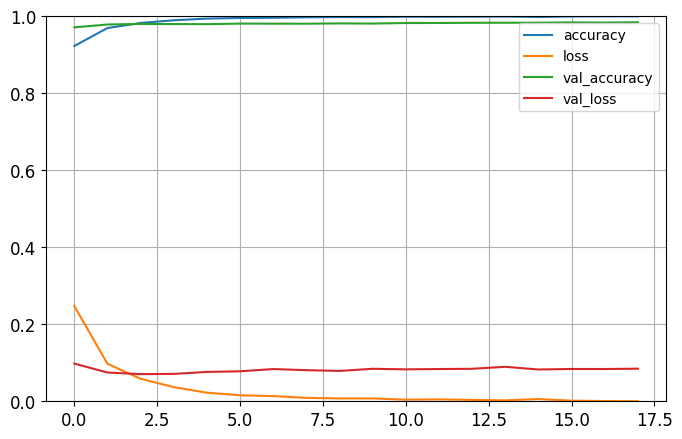

In [19]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [20]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9838 - loss: 0.0744
[test loss, test accuracy]: [0.07442931830883026, 0.9837999939918518]
